In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import sys

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import matplotlib.pyplot as plt
import numpy as np
from dataloader import DiabetesDataset
from matplotlib_style import setup_matplotlib_environment
import pandas as pd
import plots
import umap

# For making some linear models for comparison
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


In [3]:
setup_matplotlib_environment()

# Diabetes Dataset Exploration

In [4]:
diabetes_dataset = DiabetesDataset()

### Column Renaming

By default, our diabetes datset has a set of feature names which aren't very informative: 's1', 's2', 's3'... 's6' corresponding to six different blood serum measurements. Leaving these names as-
is is fine for training, but since we'll just be trying to get a bit of a conceptual understanding of the structure of the dataset here, we'll first take the step of changing these names to something more useful. 

We can find this information at the dataset's source: https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

In [5]:
feature_names_map = {
    "s1": "total serum cholesterol",
    "s2": "low-density lipoproteins",
    "s3": "high-density lipoproteins",
    "s4": "total cholesterol",
    "s5": "log serum triglyceride levels",
    "s6": "blood sugar level",
}

# Replace the feature neames in our instance of the DiabetesDataset object.
diabetes_dataset.feature_names = [feature_name if feature_name not in feature_names_map.keys() else feature_names_map[feature_name] for feature_name in diabetes_dataset.feature_names]

### Converting the data to Pandas Dataframes

Pandas is going to be a useful tool for manipulating this data, so lets make a Pandas DataFrame object for the features and labels.

In [6]:
features_df = pd.DataFrame(
    diabetes_dataset.features,
    columns=diabetes_dataset.feature_names
)

labels_df = pd.DataFrame(
    diabetes_dataset.labels, 
    columns=["disease progression"]
)

### A visual inspection of the data

We can see that we have 442 measurements, and that each measurement has 10 features, plus an 11th column for our label. We can immediately see some unusual feaures in this dataset, for one thing, the ages of our patients appear to be very small (and occasionally negative). It turns out that sklearn has already taken the step of mean normalizing this data for us (it is just a toy dataset after all). This means we can immediately begin looking at correlations and thinking about fitting models to the data without worrying about certain features dominating; very considerate.

In [7]:
whole_dataset_df = pd.concat((features_df, labels_df), axis=1)

In [8]:
print(f"Dataset Shape: {whole_dataset_df.shape}")

Dataset Shape: (442, 11)


In [9]:
whole_dataset_df

,age,sex,bmi,bp,total serum cholesterol,low-density lipoproteins,high-density lipoproteins,total cholesterol,log serum triglyceride levels,blood sugar level,disease progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


## Looking for simple correlations

Since we don't have too many features, and all of these are normalised for us, we can begin by looking for obvious correlations between particular features in our dataset. This can serve to provide us with some basic intutition in the data, and is an important debugging step for ensuring that the data have been loaded correctly. 

In particular, we are interested in looking for any features which might correlate closely with our "disease progression" label. Below, we plot a correlation matrix for our 11 data axes against one another. We can highlight a few things:

#### Positive Correlations (see correlations below)
1. **BMI** shows a 0.59 correlated with disease progression. BMI is a measure of body weight, normalised for patient height. Excessive weight gain is a recognised cause of type-2 diabetes in the medical literature and so a positive correlation here is expected. 
2. We can also that **serum triglyceride** levels are closely correlated with disease progression. Blood triglyceride levels are another marker of patient health which are typically higher in individuals who suffer from overweight, consume foods which are high in fat and sugar and do not get sufficient exercise.

#### Negative Correlations (see correlations below)
1. The blood serum concentration of **high-density lipoproteins** is weakly negatively correlated with disease progression. High-density lipoproteins are often referred to as "good cholesterol" and help support the removal of cholesterol from the blood via transport to the liver, for this reason, we observe a strong negative correlation (-0.74) between high-density lipoproteins and total cholesterol. High-density liporotein concentrations are typically higher in individuals who get significant regular exercise and consume a healthy diet, so a negative correlation of this with diabetes disease progression is logical.

#### Non-Correlations
1. We notice that patient sex has little-to-no direct correlation with disease progression, suggesting that both male and female patients respond similarly (to a first approximation).
2. Age does not appear to be as strong a predictor as one might expect. Since diabetes is a chronic condition, it may be expected to see a progression of the disease with age.
3. Perhaps surprisingly, we also note that low-density lipoprotein serum concentrations (i.e. so-called "bad cholesterol"), also does not have a strong correlation.

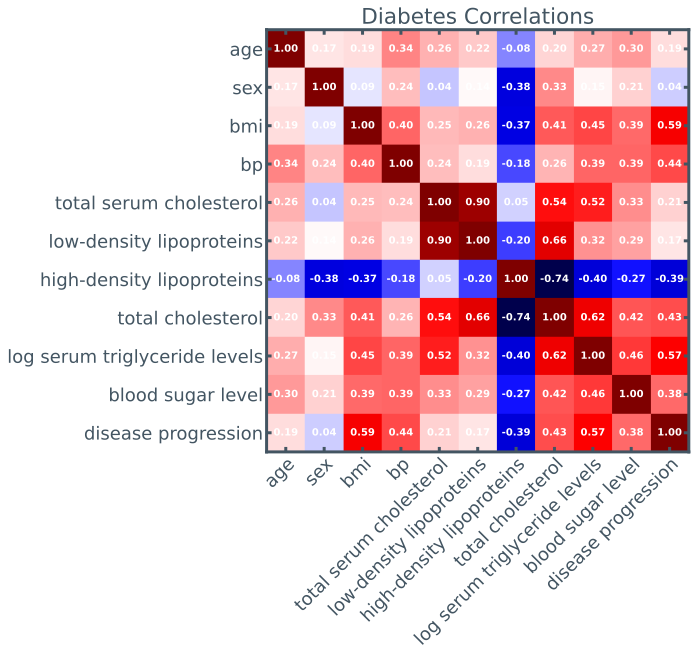

In [10]:
fig, ax = plots.plot_correlations(whole_dataset_df.corr())

### BMI

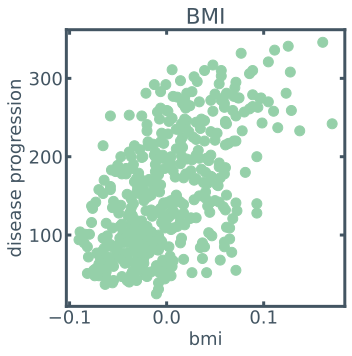

In [11]:
fig, ax = plots.plot_two_feature_correlation(whole_dataset_df["bmi"], whole_dataset_df["disease progression"], "BMI")

### Serum Triglyceride Levels

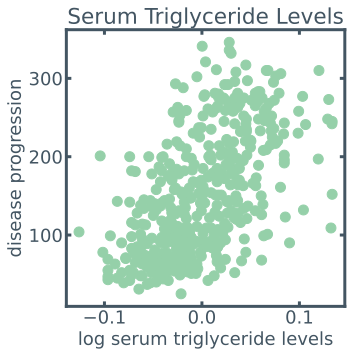

In [12]:
fig, ax = plots.plot_two_feature_correlation(whole_dataset_df["log serum triglyceride levels"], whole_dataset_df["disease progression"], "Serum Triglyceride Levels")

### High-Density Lipoproteins

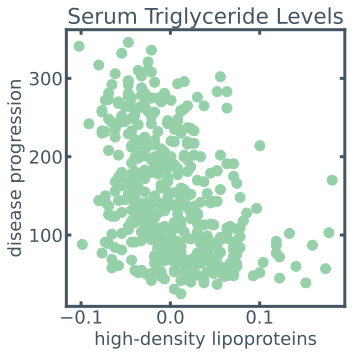

In [13]:
fig, ax = plots.plot_two_feature_correlation(whole_dataset_df["high-density lipoproteins"], whole_dataset_df["disease progression"], "Serum Triglyceride Levels")

## Reduced-Dimensionality Plot of Dataset 

In this section, we will use UMAP (Uniform Manifold Approximation and Projection) to visualize the structure of the sklearn diabetes dataset. UMAP is a dimensionality reduction technique that helps to project high-dimensional data into a lower-dimensional space (typically 2D or 3D) while preserving the global and local structure. By applying UMAP to this dataset, we aim to gain a qualitative understanding of the underlying patterns, clusters, and relationships between features. Visualizing the data in this reduced space can reveal hidden structures that may not be immediately apparent in the original high-dimensional feature space, facilitating a more intuitive exploration of the dataset.

### Generating a UMAP embedding

Lets generate a umap embedding with all of our features, we can then plot each datapoint in the reduced dimensionality space, and colour according to some of the more interesting features to gain some information on our dataset.

In [14]:
n_neighbours = 15
min_dist = 0.1
metric = "euclidean"

In [15]:
umap_model = umap.UMAP(n_neighbors=n_neighbours, min_dist=min_dist, random_state=42, metric=metric)
umap_embedding = umap_model.fit(features_df)
umap_coords = umap_embedding.transform(features_df)

/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Plotting the reduced dimensionality dataset... We notice a problem.

In this UMAP plot, we observe that the variable "sex," being a binary feature in the dataset, dominates the embedding. This happens because UMAP tries to preserve the global structure of the data, and binary variables like sex often introduce clear separations in the 2D plot. This dominance can sometimes overshadow the more subtle relationships between other features and the target variable.

To gain more meaningful insights, we will now focus on generating a plot that highlights features which show a stronger correlation with the target label. By doing this, we aim to better understand how the most relevant features influence the data and the label, allowing for a more informative and nuanced visualization.

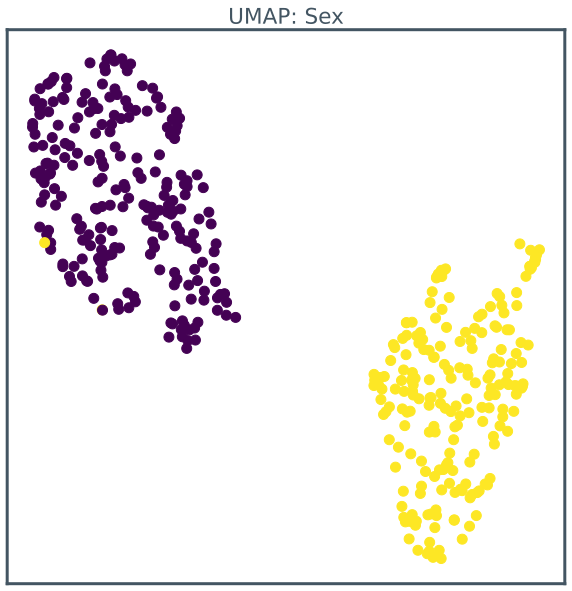

In [16]:
fig, ax = plots.plot_umap(umap_coords, features_df["sex"], title=f"UMAP: Sex")

## A UMAP embedding on a reduced set of features

Lets say we're only interested in making a UMAP plot embedding with features where the measured correlation to disease progression is greater than .4

When looking at the plots below, we can begin to see some interesting structure emerge. For one thing, we note that although we do not use the disease progression label to produce the embedding, there is a tendancy towards greater disease progression to the top left of this plot. (note that the absolute position is meaningless here, only the relative positions of one point to another). Furthermore, we can see in subsequent plots a similar tendancy of high BMI, blood pressure, and log serum triglyceride levels to be high in these areas. These sorts of structures emerging from thge dataset are promising indications that a model can be trained to regress the disease progression based on our features. 

In [17]:
correlation_threshold = 0.4

# Filter according to our threshold, then drop the label and cast to list
correlated_variables = list(whole_dataset_df.columns[whole_dataset_df.corr()["disease progression"].abs() > correlation_threshold].drop("disease progression"))
print(f"Correlated Variables: {correlated_variables}")

Correlated Variables: ['bmi', 'bp', 'total cholesterol', 'log serum triglyceride levels']


In [18]:
umap_model = umap.UMAP(n_neighbors=n_neighbours, min_dist=min_dist, metric=metric, random_state=4)
umap_embedding = umap_model.fit(features_df[correlated_variables])
umap_coords = umap_embedding.transform(features_df)

/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


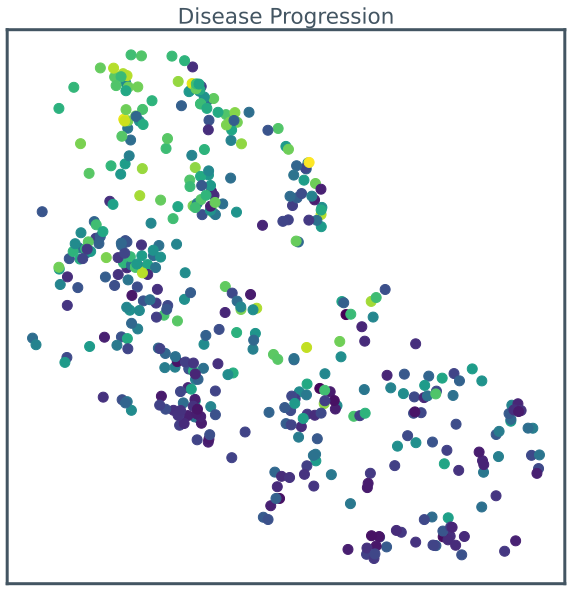

In [19]:
fig, ax = plots.plot_umap(umap_coords, labels_df["disease progression"], title="Disease Progression")

In [1]:
for column in correlated_variables:
    fig, ax = plots.plot_umap(umap_coords, features_df[column], title=f"UMAP: {column}")

NameError: name 'correlated_variables' is not defined

[array([219.,  70., 202., 230., 111.,  84., 242., 272.,  94.,  96.,  94.,
       252.,  99., 297., 135.,  67., 295., 264., 170., 275., 310.,  64.,
       128., 232., 129., 118., 263.,  77.,  48., 107., 140., 113.,  90.,
       164., 180., 233.,  42.,  84., 172.,  63.,  48., 108., 156., 168.,
        90.,  52., 200.,  87.,  90., 258., 136., 158.,  69.,  72., 171.,
        95.,  72., 151., 168.,  60., 122.,  52., 187., 102., 214., 248.,
       181., 110., 140., 202., 101., 222., 281.,  61.,  89.,  91., 186.,
       220., 237., 233.,  68., 190.,  96.,  72., 153.,  98.,  37.,  63.,
       184.]), array([144., 150., 280., 125.,  59.,  65., 281., 277., 167.,  90.,  72.,
       178.,  88., 270., 101., 197.,  97.,  53.,  71., 262.,  52., 102.,
       166., 189., 173., 220., 206.,  97.,  60.,  61., 242., 121., 128.,
       104., 265., 132., 283., 174., 129., 257., 137.,  63.,  93., 232.,
       208., 261., 179., 258., 262.,  51., 237.,  71., 139., 268.,  69.,
       317., 249., 154., 192., 116.

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

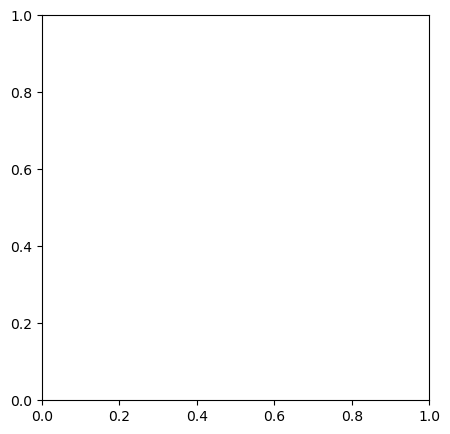

In [ ]:
# Load the diabetes dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

y = [y_test, y_train]
y_hat = [y_pred, model.predict(X_train)]

fig, ax = plots.correlate_y_vs_yhat(y, y_hat)


Mean Squared Error: 3077.41593882723
R-squared: 0.41915292635986545


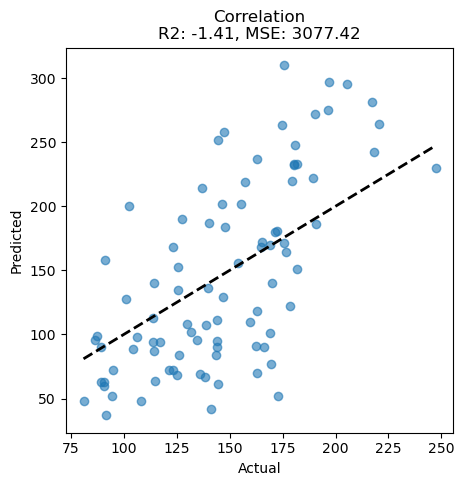

In [15]:
# Initialize the ridge regression model
ridge_model = Ridge(alpha=1.0)

# Fit the model to the training data
ridge_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ridge_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

fig, ax = plots.correlate_y_vs_yhat(y_test, y_pred)


Mean Squared Error: 3096.0283073442506
R-squared: 0.4156399336408042


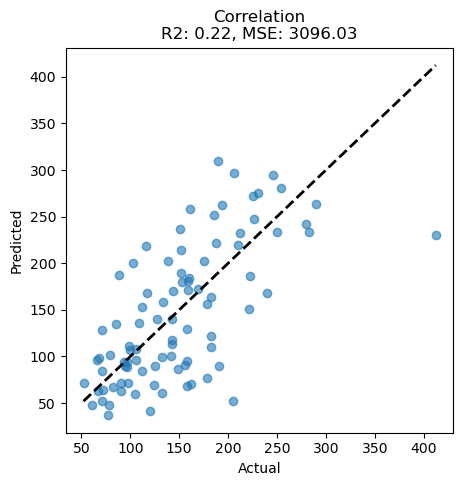

In [16]:
# Create a polynomial regression pipeline
degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

fig, ax = plots.correlate_y_vs_yhat(y_test, y_pred)
